In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error # for RMSE
from patsy import dmatrices
from sklearn.linear_model import LinearRegression # for OLS
from sklearn.linear_model import ElasticNet # for LASSO
from sklearn.model_selection import GridSearchCV # for Gridsearch CV
from sklearn.preprocessing import StandardScaler # for standardization
from sklearn.tree import DecisionTreeRegressor # for Decision Tree
from sklearn.model_selection import RandomizedSearchCV # for Randomized Search CV
from sklearn import tree # for plotting trees
from sklearn.ensemble import RandomForestRegressor # for Random Forest
from sklearn.ensemble import GradientBoostingRegressor # for Gradient Boosting
from sklearn.pipeline import Pipeline # for pipelines
from sklearn.compose import ColumnTransformer # for column transformer


## 1. Introduction & Data

In this assignment I analysed the Airbnb prices in Sicily 2025Q2. I built 5 different statistical models (OLS, LASSO, CART, Random Forest, GBM boosting) to predict the prices. For the evaluation of the models I used 2 holdout datasets (Airbnb prices in Sicily 2025Q3 and Airbnb prices in Puglia 2025Q3). In the analysis I reported the prediction error of all 3 datasets.

In [2]:
# Set URLs for the CSV files
url1 = "https://github.com/benceszabo89/Data-Analysis-3/raw/main/assignment1/Data/Raw/listings_Puglia_2025Q3.csv"
url2 = "https://github.com/benceszabo89/Data-Analysis-3/raw/main/assignment1/Data/Raw/listings_Sicily_2025Q3.csv"
url3 = "https://github.com/benceszabo89/Data-Analysis-3/raw/main/assignment1/Data/Raw/listings_Sicily_2025Q2.csv"

# Import the CSV files
df_holdout_city = pd.read_csv(url1, storage_options={"User-Agent": "pandas"})
df_holdout_time = pd.read_csv(url2, storage_options={"User-Agent": "pandas"})
df_train = pd.read_csv(url3, storage_options={"User-Agent": "pandas"})

## 2. Data wrangling

I created 2 cleaning functions for the datasets. The first one selects the important features of the datasets and does the basic data cleaning (cleans the target variable, creates the amenities dummies, creates dummies for room types, bathrooms, kid-friendliness and superhost status). Overall I analysed the following features:
1. basic listing features:
	- accommodates: number of accommodates
	- beds: number of beds
	- bathrooms: number of bathrooms
	- d_apartment: indicator for apartments (room type)
	- d_private_room: indicator for private rooms (room type)
	- d_shared_room: indicator for shared rooms (room type)
	- minimum_nights: minimum nights required for booking
2. other listing features:
	- n_amenities: number of amenities
	- d_kids_amenities: indicator for any kid amenities
	- d_bath_private: indicator for private bath (bathroom type)
	- d_bath_shared: indicator for shared bath (bathroom type)
3. amenities:
	- d_amenity_kitchen,
 	- d_amenity_wifi,
 	- d_amenity_heating,
 	- d_amenity_cooking_basics,
 	- d_amenity_air_conditioning,
 	- d_amenity_luggage_dropoff_allowed,
 	- d_amenity_tv,
 	- d_amenity_pets_allowed,
 	- d_amenity_free_street_parking,
 	- d_amenity_private_entrance,
 	- d_amenity_dedicated_workspace,
 	- d_amenity_patio_or_balcony,
 	- d_amenity_sea_view,
 	- d_amenity_waterfront,
	- d_amenity_elevator,
 	- d_amenity_self_check_in
4. host features:
	- d_superhost
5. listing reviews
	- number_of_reviews
	- review_scores_rating

I filtered out the listings with missing prices and also the listings where minimum nights required were more than 14 days as I wanted to analyse short-term rentals.

The second cleaning function drops rows where the target variable is missing, inputs the missing values with 1 in bathrooms and bedrooms and with the median in review scores. I ran the data wrangling functions in all 3 datasets.

In [3]:
# Data wrangling 1

# 1. define cleaning function #1
def clean_listings_1(df):
    # create copy to avoid modifying original dataframes
    df = df.copy()
    # filter columns to keep only relevant ones
    keep_cols = [   # host features
                    'host_is_superhost',
                    # listing features
                    'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 
                    'bedrooms', 'beds', 'minimum_nights',
                    # amenities
                    'amenities',
                    # reviews
                    'number_of_reviews', 
                    'review_scores_rating',
                    # target
                    'price']
    #  keep columns that actually exist in the dataframe
    actual_cols = [c for c in keep_cols if c in df.columns]
    df = df[actual_cols]

    # convert price to clean numeric value
    if df['price'].dtype == 'O':
        df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)

    # create number of amenities column by counting commas + 1
    df['n_amenities'] = df['amenities'].str.count(',') + 1

    # split the amenities into separate dummies keeping only important ones
    important_amenities = [ "Crib",
    "Children\u2019s books and toys",
    "Children\u2019s dinnerware",
    "Children\u2019s bikes",
    "Children\u2019s books and toys for ages 0-2 years old",
    "Children's playroom",
    "Children\u2019s books and toys for ages 2-5 years old",
    "Children\u2019s books and toys for ages 0-2 years old and 2-5 years old",
    "Children\u2019s books and toys for ages 2-5 years old and 5-10 years old",
    "Children\u2019s books and toys for ages 0-2 years old",
    "Children\u2019s books and toys",
    "Children\u2019s books and toys for ages 2-5 years old",
    "Children\u2019s books and toys for ages 2-5 years old",
    "Children\u2019s books and toys for ages 0-2 years old",
    "Children\u2019s books and toys for ages 2-5 years old",
    "Children's playroom",
    "Children\u2019s dinnerware",
    "Kitchen",
    "Wifi",
    "Heating",
    "Cooking basics",
    "Air conditioning",
    "Luggage dropoff allowed",
    "TV",
    "Pets allowed",
    "Free street parking",
    "Private entrance",
    "Dedicated workspace",
    "Self check-in",
    "Patio or balcony",
    "Sea view",
    "Waterfront",
    "Elevator"
    ]

    for amenity in important_amenities:
        col_name = f"d_amenity_{amenity.replace(' ', '_').lower()}"
        df[col_name] = df['amenities'].str.contains(amenity, regex=False).fillna(False).astype(int)
    df['d_amenity_self_check_in'] = df['d_amenity_self_check-in']

    # create dummies from room type
    df['d_shared_room'] = np.where(df['room_type'] == 'Shared room', 1, 0)
    df['d_apartment'] = np.where(df['room_type'] == 'Entire home/apt', 1, 0)
    df['d_private_room'] = np.where((df['room_type'] == 'Hotel room') | (df['room_type'] == 'Private room'), 1, 0)

    # create dummies from bathrooms_text
    df['d_bath_shared'] = np.where(df['bathrooms_text'].str.contains('shared', case=False, na=False), 1, 0)
    df['d_bath_private'] = np.where((df['bathrooms_text'].str.contains('bath', case=False, na=False)) & (df['d_bath_shared'] == 0), 1, 0)
    df['d_bath_shared'] = np.where(df[['d_bath_shared', 'd_bath_private']].max(axis=1) == 0, 1, 0)
                                    
    # merge columns where column names include 'children' or 'crib'
    kids_cols = [col for col in df.columns if 'children' in col or 'crib' in col]
    df['d_kids_amenities'] = df[kids_cols].max(axis=1)
    df.drop(columns=kids_cols, inplace=True)

    # convert superhost to dummy
    df['host_is_superhost'] = np.where(df['host_is_superhost'] == 't', 1, 0)

    # drop original amenities and room_type and bathrooms_text columns
    df.drop(columns=['amenities', 'room_type', 'bathrooms_text', 'd_amenity_self_check-in'], inplace=True)
    return df

# 2. run cleaning function #1
df_train_clean = clean_listings_1(df_train)
df_holdout_time_clean = clean_listings_1(df_holdout_time)
df_holdout_city_clean = clean_listings_1(df_holdout_city)
df_train_clean.head()

,host_is_superhost,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,price,n_amenities,...,d_amenity_sea_view,d_amenity_waterfront,d_amenity_elevator,d_amenity_self_check_in,d_shared_room,d_apartment,d_private_room,d_bath_shared,d_bath_private,d_kids_amenities
0,0,6,3.0,3.0,4.0,3,33,4.69,219.0,47,...,0,0,0,1,0,1,0,0,1,1
1,1,2,1.0,1.0,1.0,1,442,4.81,47.0,33,...,0,0,0,0,0,0,1,0,0,0
2,1,14,3.0,3.0,8.0,1,159,4.79,109.0,55,...,1,0,0,1,0,1,0,0,1,1
3,1,5,2.0,2.0,4.0,5,72,4.69,108.0,47,...,1,1,1,0,0,1,0,0,1,1
4,1,8,2.0,3.0,8.0,5,71,4.84,154.0,55,...,0,0,0,0,0,1,0,0,1,1


In [4]:
# check missing values in each column
def missing_check(df):
    missing_count = df.isnull().sum()
    missing_ratio = df.isnull().mean()

    summary_table = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Ratio': missing_ratio
    })

    # sort by ratio
    summary_table = summary_table.sort_values(by='Missing Ratio', ascending=False)
    summary_table = summary_table[summary_table['Missing Count'] > 0]
    return summary_table

print(missing_check(df_train_clean))
print(missing_check(df_holdout_time_clean))
print(missing_check(df_holdout_city_clean))

                      Missing Count  Missing Ratio
review_scores_rating          17429       0.312404
beds                           4454       0.079835
price                          4452       0.079799
bathrooms                      4447       0.079710
bedrooms                        766       0.013730
                      Missing Count  Missing Ratio
review_scores_rating          15940       0.277068
bathrooms                      5671       0.098573
beds                           5670       0.098556
price                          5642       0.098069
bedrooms                        978       0.017000
                      Missing Count  Missing Ratio
review_scores_rating          15256       0.314213
beds                           5648       0.116326
bathrooms                      5634       0.116038
price                          5630       0.115956
bedrooms                        803       0.016539


In [5]:
# group by minimum nights
nights_dist = df_train_clean.groupby('minimum_nights').size().reset_index(name='count')
nights_dist.head(30)

,minimum_nights,count
0,1,17764
1,2,12277
2,3,8069
3,4,2307
4,5,1990
5,6,617
6,7,1336
7,8,10
8,9,3
9,10,17


In [6]:
# check how many listings have minimum nights <= 14
len(df_train_clean[df_train_clean['minimum_nights'] <= 14])

44408

In [7]:
# Data wrangling 2
# 1. define cleaning function #2
def clean_listings_2(df):
    # drop rows where target variable (price) is missing
    df = df.dropna(subset=['price'])
    # keep listings where have minimum nights <= 14 (short term rentals)
    df = df[df['minimum_nights'] <= 14]
    # rename 'host_is_superhost' to 'd_superhost' for consistency
    df = df.rename(columns={'host_is_superhost': 'd_superhost'})
    # Handle missings
    df['beds'] = df['beds'].fillna(df['accommodates'])
    df['bathrooms'] = df['bathrooms'].fillna(1)
    df['bedrooms'] = df['bedrooms'].fillna(1)
    df['review_scores_rating']=df['review_scores_rating'].fillna(np.nanmedian(df['review_scores_rating']))
    return df

# 2. run cleaning function #2
df_train_clean = clean_listings_2(df_train_clean)
df_holdout_time_clean = clean_listings_2(df_holdout_time_clean)
df_holdout_city_clean = clean_listings_2(df_holdout_city_clean)
df_train_clean.head()


,d_superhost,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,price,n_amenities,...,d_amenity_sea_view,d_amenity_waterfront,d_amenity_elevator,d_amenity_self_check_in,d_shared_room,d_apartment,d_private_room,d_bath_shared,d_bath_private,d_kids_amenities
0,0,6,3.0,3.0,4.0,3,33,4.69,219.0,47,...,0,0,0,1,0,1,0,0,1,1
1,1,2,1.0,1.0,1.0,1,442,4.81,47.0,33,...,0,0,0,0,0,0,1,0,0,0
2,1,14,3.0,3.0,8.0,1,159,4.79,109.0,55,...,1,0,0,1,0,1,0,0,1,1
3,1,5,2.0,2.0,4.0,5,72,4.69,108.0,47,...,1,1,1,0,0,1,0,0,1,1
4,1,8,2.0,3.0,8.0,5,71,4.84,154.0,55,...,0,0,0,0,0,1,0,0,1,1


In [8]:
# check missing values in each column again
print(missing_check(df_train_clean))
print(missing_check(df_holdout_time_clean))
print(missing_check(df_holdout_city_clean))

Empty DataFrame
Columns: [Missing Count, Missing Ratio]
Index: []
Empty DataFrame
Columns: [Missing Count, Missing Ratio]
Index: []
Empty DataFrame
Columns: [Missing Count, Missing Ratio]
Index: []


## 3. Modelling

I built 3 different models, starting with the simplest one to the more complex ML boosting algorithm and reported the summary of the model performance for comparison.

### 3.1 OLS

I built 5 models, adding more and more features from the above categories. The simplest model has 6, and the most complex model has 28 features. I saw that both the train and holdout RMSEs dropped in case of the 3rd model with 25 features. I looked at the coefficients and the direction of the coefficients seems to be reasonable, for example the price increases with the number of accommodates, number of beds and bathrooms, if the room type is an apartment or a private room compared to a shared room, etc. The price decreases if the minimum nights requirement increases.

In [9]:
# Define predictor lists
listing_basic_features = ['accommodates', 'beds', 'bathrooms', 
                          'd_apartment', 'd_private_room',  # reference is the shared room
                          'minimum_nights']
listing_other_features = ['n_amenities', 'd_kids_amenities',
                          'd_bath_private'  # reference is the shared bathroom 
                          ]
amenities = list(df_train_clean.filter(regex="^d_amenity_.*"))
host_features = ['d_superhost']
listing_reviews = ['number_of_reviews', 'review_scores_rating']

In [10]:
ols_model_1 = "price~" + "+".join(listing_basic_features)
ols_model_2 = "price~" + "+".join(listing_basic_features)+"+"+"+".join(listing_other_features)
ols_model_3 = "price~" + "+".join(listing_basic_features)+"+"+"+".join(listing_other_features)+"+"+"+".join(amenities)
ols_model_4 = "price~" + "+".join(listing_basic_features)+"+"+"+".join(listing_other_features)+"+"+"+".join(amenities)+"+"+"+".join(host_features)
ols_model_5 = "price~" + "+".join(listing_basic_features)+"+"+"+".join(listing_other_features)+"+"+"+".join(amenities)+"+"+"+".join(host_features)+"+"+"+".join(listing_reviews)

In [11]:
# Define OLS models

# Model 1
num_features_ols_1 = len(ols_model_1.split('~')[1].split('+')) 
y_train, X_train = dmatrices(ols_model_1, df_train_clean)
y_holdout_city, X_holdout_city = dmatrices(ols_model_1, df_holdout_city_clean)
y_holdout_time, X_holdout_time = dmatrices(ols_model_1, df_holdout_time_clean)

ols_1 = LinearRegression().fit(X_train, y_train)

price_pred_ols_1_train = ols_1.predict(X_train)
price_pred_ols_1_holdout_city = ols_1.predict(X_holdout_city)
price_pred_ols_1_holdout_time = ols_1.predict(X_holdout_time)

rmse_ols_1_train = mean_squared_error(y_train, price_pred_ols_1_train, squared=False)
rmse_ols_1_holdout_city = mean_squared_error(y_holdout_city, price_pred_ols_1_holdout_city, squared=False)
rmse_ols_1_holdout_time = mean_squared_error(y_holdout_time, price_pred_ols_1_holdout_time, squared=False)

# Model 2
num_features_ols_2 = len(ols_model_2.split('~')[1].split('+')) 
y_train, X_train = dmatrices(ols_model_2, df_train_clean)
y_holdout_city, X_holdout_city = dmatrices(ols_model_2, df_holdout_city_clean)
y_holdout_time, X_holdout_time = dmatrices(ols_model_2, df_holdout_time_clean)

ols_2 = LinearRegression().fit(X_train, y_train)

price_pred_ols_2_train = ols_2.predict(X_train)
price_pred_ols_2_holdout_city = ols_2.predict(X_holdout_city)
price_pred_ols_2_holdout_time = ols_2.predict(X_holdout_time)

rmse_ols_2_train = mean_squared_error(y_train, price_pred_ols_2_train, squared=False)
rmse_ols_2_holdout_city = mean_squared_error(y_holdout_city, price_pred_ols_2_holdout_city, squared=False)
rmse_ols_2_holdout_time = mean_squared_error(y_holdout_time, price_pred_ols_2_holdout_time, squared=False)

# Model 3
num_features_ols_3 = len(ols_model_3.split('~')[1].split('+')) 
y_train, X_train = dmatrices(ols_model_3, df_train_clean)
y_holdout_city, X_holdout_city = dmatrices(ols_model_3, df_holdout_city_clean)
y_holdout_time, X_holdout_time = dmatrices(ols_model_3, df_holdout_time_clean)

ols_3 = LinearRegression().fit(X_train, y_train)

price_pred_ols_3_train = ols_3.predict(X_train)
price_pred_ols_3_holdout_city = ols_3.predict(X_holdout_city)
price_pred_ols_3_holdout_time = ols_3.predict(X_holdout_time)

rmse_ols_3_train = mean_squared_error(y_train, price_pred_ols_3_train, squared=False)
rmse_ols_3_holdout_city = mean_squared_error(y_holdout_city, price_pred_ols_3_holdout_city, squared=False)
rmse_ols_3_holdout_time = mean_squared_error(y_holdout_time, price_pred_ols_3_holdout_time, squared=False)

# Model 4
num_features_ols_4 = len(ols_model_4.split('~')[1].split('+')) 
y_train, X_train = dmatrices(ols_model_4, df_train_clean)
y_holdout_city, X_holdout_city = dmatrices(ols_model_4, df_holdout_city_clean)
y_holdout_time, X_holdout_time = dmatrices(ols_model_4, df_holdout_time_clean)

ols_4 = LinearRegression().fit(X_train, y_train)

price_pred_ols_4_train = ols_4.predict(X_train)
price_pred_ols_4_holdout_city = ols_4.predict(X_holdout_city)
price_pred_ols_4_holdout_time = ols_4.predict(X_holdout_time)

rmse_ols_4_train = mean_squared_error(y_train, price_pred_ols_4_train, squared=False)
rmse_ols_4_holdout_city = mean_squared_error(y_holdout_city, price_pred_ols_4_holdout_city, squared=False)
rmse_ols_4_holdout_time = mean_squared_error(y_holdout_time, price_pred_ols_4_holdout_time, squared=False)

# Model 5
num_features_ols_5 = len(ols_model_5.split('~')[1].split('+')) 
y_train, X_train = dmatrices(ols_model_5, df_train_clean)
y_holdout_city, X_holdout_city = dmatrices(ols_model_5, df_holdout_city_clean)
y_holdout_time, X_holdout_time = dmatrices(ols_model_5, df_holdout_time_clean)

ols_5 = LinearRegression().fit(X_train, y_train)

price_pred_ols_5_train = ols_5.predict(X_train)
price_pred_ols_5_holdout_city = ols_5.predict(X_holdout_city)
price_pred_ols_5_holdout_time = ols_5.predict(X_holdout_time)

rmse_ols_5_train = mean_squared_error(y_train, price_pred_ols_5_train, squared=False)
rmse_ols_5_holdout_city = mean_squared_error(y_holdout_city, price_pred_ols_5_holdout_city, squared=False)
rmse_ols_5_holdout_time = mean_squared_error(y_holdout_time, price_pred_ols_5_holdout_time, squared=False)



In [12]:
# Model performance summary
df_results = pd.DataFrame({
    'Model': ['OLS Model 1', 'OLS Model 2', 'OLS Model 3', 'OLS Model 4', 'OLS Model 5'],
    'Number of features': [num_features_ols_1, num_features_ols_2, num_features_ols_3, num_features_ols_4, num_features_ols_5],
    'RMSE Train': [rmse_ols_1_train, rmse_ols_2_train, rmse_ols_3_train, rmse_ols_4_train, rmse_ols_5_train],
    'RMSE CV Train': ['NA', 'NA', 'NA', 'NA', 'NA'],
    'RMSE Holdout City': [rmse_ols_1_holdout_city, rmse_ols_2_holdout_city, rmse_ols_3_holdout_city, rmse_ols_4_holdout_city, rmse_ols_5_holdout_city],
    'RMSE Holdout Time': [rmse_ols_1_holdout_time, rmse_ols_2_holdout_time, rmse_ols_3_holdout_time, rmse_ols_4_holdout_time, rmse_ols_5_holdout_time]
})
df_results

,Model,Number of features,RMSE Train,RMSE CV Train,RMSE Holdout City,RMSE Holdout Time
0,OLS Model 1,6,1565.832576,NA,1531.476722,1498.686062
1,OLS Model 2,9,1551.918126,NA,1522.626715,1485.525749
2,OLS Model 3,25,1477.991406,NA,1475.320388,1426.916668
3,OLS Model 4,26,1475.062488,NA,1475.829775,1423.909328
4,OLS Model 5,28,1473.227814,NA,1475.378903,1423.235854


In [13]:
# Coefficients table of selected OLS model (model 3)
y_train, X_train = dmatrices(ols_model_3, df_train_clean)
ols_model_3_coeffs_df = pd.DataFrame(
    ols_3.coef_.tolist()[0],
    index=X_train.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))
ols_model_3_coeffs_df

,ols_coefficient
Intercept,0.000
accommodates,30.601
beds,37.852
bathrooms,70.463
d_apartment,432.980
d_private_room,68.947
minimum_nights,-159.568
n_amenities,-17.654
d_kids_amenities,281.607
d_bath_private,35.426


### 3.2 LASSO

I ran the LASSO selection with the most extensive list of features, including all the above features. The LASSO selected 27 variables for the analysis. I saw significant overlap with the 3rd OLS model in terms of the selected features. We can see only a slight decrease in the train and test RMSEs.

In [14]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [15]:
y_train, X_train = dmatrices(ols_model_5, df_train_clean)
y_holdout_city, X_holdout_city = dmatrices(ols_model_5, df_holdout_city_clean)
y_holdout_time, X_holdout_time = dmatrices(ols_model_5, df_holdout_time_clean)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_city_scaled = scaler.transform(X_holdout_city)
X_holdout_time_scaled = scaler.transform(X_holdout_time)

# Fit model on training data
lasso_model_cv.fit(X_train_scaled, y_train.ravel())
lasso_model_cv.best_estimator_
lasso_cv_rmse_train = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1

# Get the number of non/zero coefficients
lasso_coefs = lasso_model_cv.best_estimator_.coef_
n_non_zero = np.sum(lasso_coefs != 0)

# Make predictions 
pred_train = lasso_model_cv.predict(X_train_scaled)
pred_holdout_city = lasso_model_cv.predict(X_holdout_city_scaled)
pred_holdout_time = lasso_model_cv.predict(X_holdout_time_scaled)

# Calclate RMSE
lasso_rmse_train = mean_squared_error(y_train, pred_train, squared=False)
lasso_rmse_holdout_city = mean_squared_error(y_holdout_city, pred_holdout_city, squared=False)
lasso_rmse_holdout_time = mean_squared_error(y_holdout_time, pred_holdout_time, squared=False)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....................alpha=0.05;, score=-861.464 total time=  12.2s
[CV 2/5] END .....................alpha=0.05;, score=-976.248 total time=   3.8s
[CV 3/5] END ....................alpha=0.05;, score=-1435.610 total time=   0.5s
[CV 4/5] END ....................alpha=0.05;, score=-1653.035 total time=   2.6s
[CV 5/5] END ....................alpha=0.05;, score=-2273.693 total time=   6.0s
[CV 1/5] END ......................alpha=0.1;, score=-861.318 total time=   2.5s
[CV 2/5] END ......................alpha=0.1;, score=-976.122 total time=   2.5s
[CV 3/5] END .....................alpha=0.1;, score=-1435.614 total time=   0.8s
[CV 4/5] END .....................alpha=0.1;, score=-1653.075 total time=   3.3s
[CV 5/5] END .....................alpha=0.1;, score=-2273.765 total time=   4.4s
[CV 1/5] END .....................alpha=0.15;, score=-861.173 total time=   0.1s
[CV 2/5] END .....................alpha=0.15;, sc

In [16]:
# Get the coefficients table with the non/zero coefficients
feature_names = X_train.design_info.column_names
coefficients = lasso_model_cv.best_estimator_.coef_
df_lasso_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
df_nonzero = df_lasso_coefs[df_lasso_coefs['Coefficient'] != 0].copy()

# Sort by absolute impact (optional, but helpful to see most important features)
df_nonzero['Abs_Coefficient'] = df_nonzero['Coefficient'].abs()
df_nonzero = df_nonzero.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')
df_nonzero

,Feature,Coefficient
7,n_amenities,-275.980743
21,d_amenity_patio_or_balcony,275.473738
6,minimum_nights,-237.753998
22,d_amenity_sea_view,209.190860
19,d_amenity_private_entrance,188.972679
4,d_apartment,148.161196
15,d_amenity_luggage_dropoff_allowed,-142.970369
8,d_kids_amenities,139.739248
10,d_amenity_kitchen,-134.339853
26,d_superhost,-82.724335


In [17]:
# Add LASSO results to model performance summary table
new_row = pd.DataFrame({
    'Model': ['LASSO'],
    'Number of features': [n_non_zero],  # From your previous step
    'RMSE Train': [lasso_rmse_train],
    'RMSE CV Train': [lasso_cv_rmse_train],
    'RMSE Holdout City': [lasso_rmse_holdout_city],
    'RMSE Holdout Time': [lasso_rmse_holdout_time]
})

# Concatenate with the existing summary table
df_results = pd.concat([df_results, new_row], ignore_index=True)
df_results

,Model,Number of features,RMSE Train,RMSE CV Train,RMSE Holdout City,RMSE Holdout Time
0,OLS Model 1,6,1565.832576,NA,1531.476722,1498.686062
1,OLS Model 2,9,1551.918126,NA,1522.626715,1485.525749
2,OLS Model 3,25,1477.991406,NA,1475.320388,1426.916668
3,OLS Model 4,26,1475.062488,NA,1475.829775,1423.909328
4,OLS Model 5,28,1473.227814,NA,1475.378903,1423.235854
5,LASSO,27,1473.230799,1439.889464,1475.197130,1423.198736


### 3.3 CART

Next I ran a regression tree with pruning where I set the maximum depth of 5 to avoid too complex models. For the model selection I used cross-validated RMSE. The model ended with 17 final nodes and it used 9 different features. From the feature importance chart we can see that all the selected features (minimum nights, luggage drop-off, balcony, private entrance, sea view, number of amenities, superhost status, number of reviews and number of bathrooms) have more than 1% importance. The model produces slightly lower RMSE than the previous models.

In [18]:
seed = 20260202
y_train, X_train = dmatrices(ols_model_5, df_train_clean)
y_holdout_city, X_holdout_city = dmatrices(ols_model_5, df_holdout_city_clean)
y_holdout_time, X_holdout_time = dmatrices(ols_model_5, df_holdout_time_clean)

# Fit CART model on training data
cart_model = DecisionTreeRegressor(random_state=seed, max_depth=5) # max depth fixed at 5 before pruning to avoid too complex model
path = cart_model.cost_complexity_pruning_path(X_train, y_train.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Randomized Search CV for hyperparameter tuning
cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv = 5,
    scoring="neg_root_mean_squared_error",
    verbose = 3,
)
cart_model_cv.fit(X_train,y_train.ravel())
cart_model_cv.best_estimator_
cart_cv_rmse_train = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1

# Get the number of used fetures
importances = cart_model_cv.best_estimator_.feature_importances_
n_used_features = np.sum(importances > 0)

# Make predictions
pred_cart_train = cart_model_cv.predict(X_train)
pred_cart_holdout_city = cart_model_cv.predict(X_holdout_city)
pred_cart_holdout_time = cart_model_cv.predict(X_holdout_time)

# Calculate RMSE
cart_rmse_train = mean_squared_error(y_train, pred_cart_train, squared=False)
cart_rmse_holdout_city = mean_squared_error(y_holdout_city, pred_cart_holdout_city, squared=False)
cart_rmse_holdout_time = mean_squared_error(y_holdout_time, pred_cart_holdout_time, squared=False)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....ccp_alpha=94.6249060001769;, score=-688.032 total time=   0.0s
[CV 2/5] END ....ccp_alpha=94.6249060001769;, score=-1000.303 total time=   0.0s
[CV 3/5] END ....ccp_alpha=94.6249060001769;, score=-1413.641 total time=   0.0s
[CV 4/5] END ....ccp_alpha=94.6249060001769;, score=-1519.121 total time=   0.0s
[CV 5/5] END ....ccp_alpha=94.6249060001769;, score=-2058.881 total time=   0.0s
[CV 1/5] END ....ccp_alpha=93.54576670090273;, score=-688.032 total time=   0.0s
[CV 2/5] END ...ccp_alpha=93.54576670090273;, score=-1000.303 total time=   0.0s
[CV 3/5] END ...ccp_alpha=93.54576670090273;, score=-1413.641 total time=   0.0s
[CV 4/5] END ...ccp_alpha=93.54576670090273;, score=-1519.101 total time=   0.0s
[CV 5/5] END ...ccp_alpha=93.54576670090273;, score=-2058.881 total time=   0.0s
[CV 1/5] END ....ccp_alpha=839.6038685996937;, score=-685.832 total time=   0.0s
[CV 2/5] END ...ccp_alpha=839.6038685996937;, sc

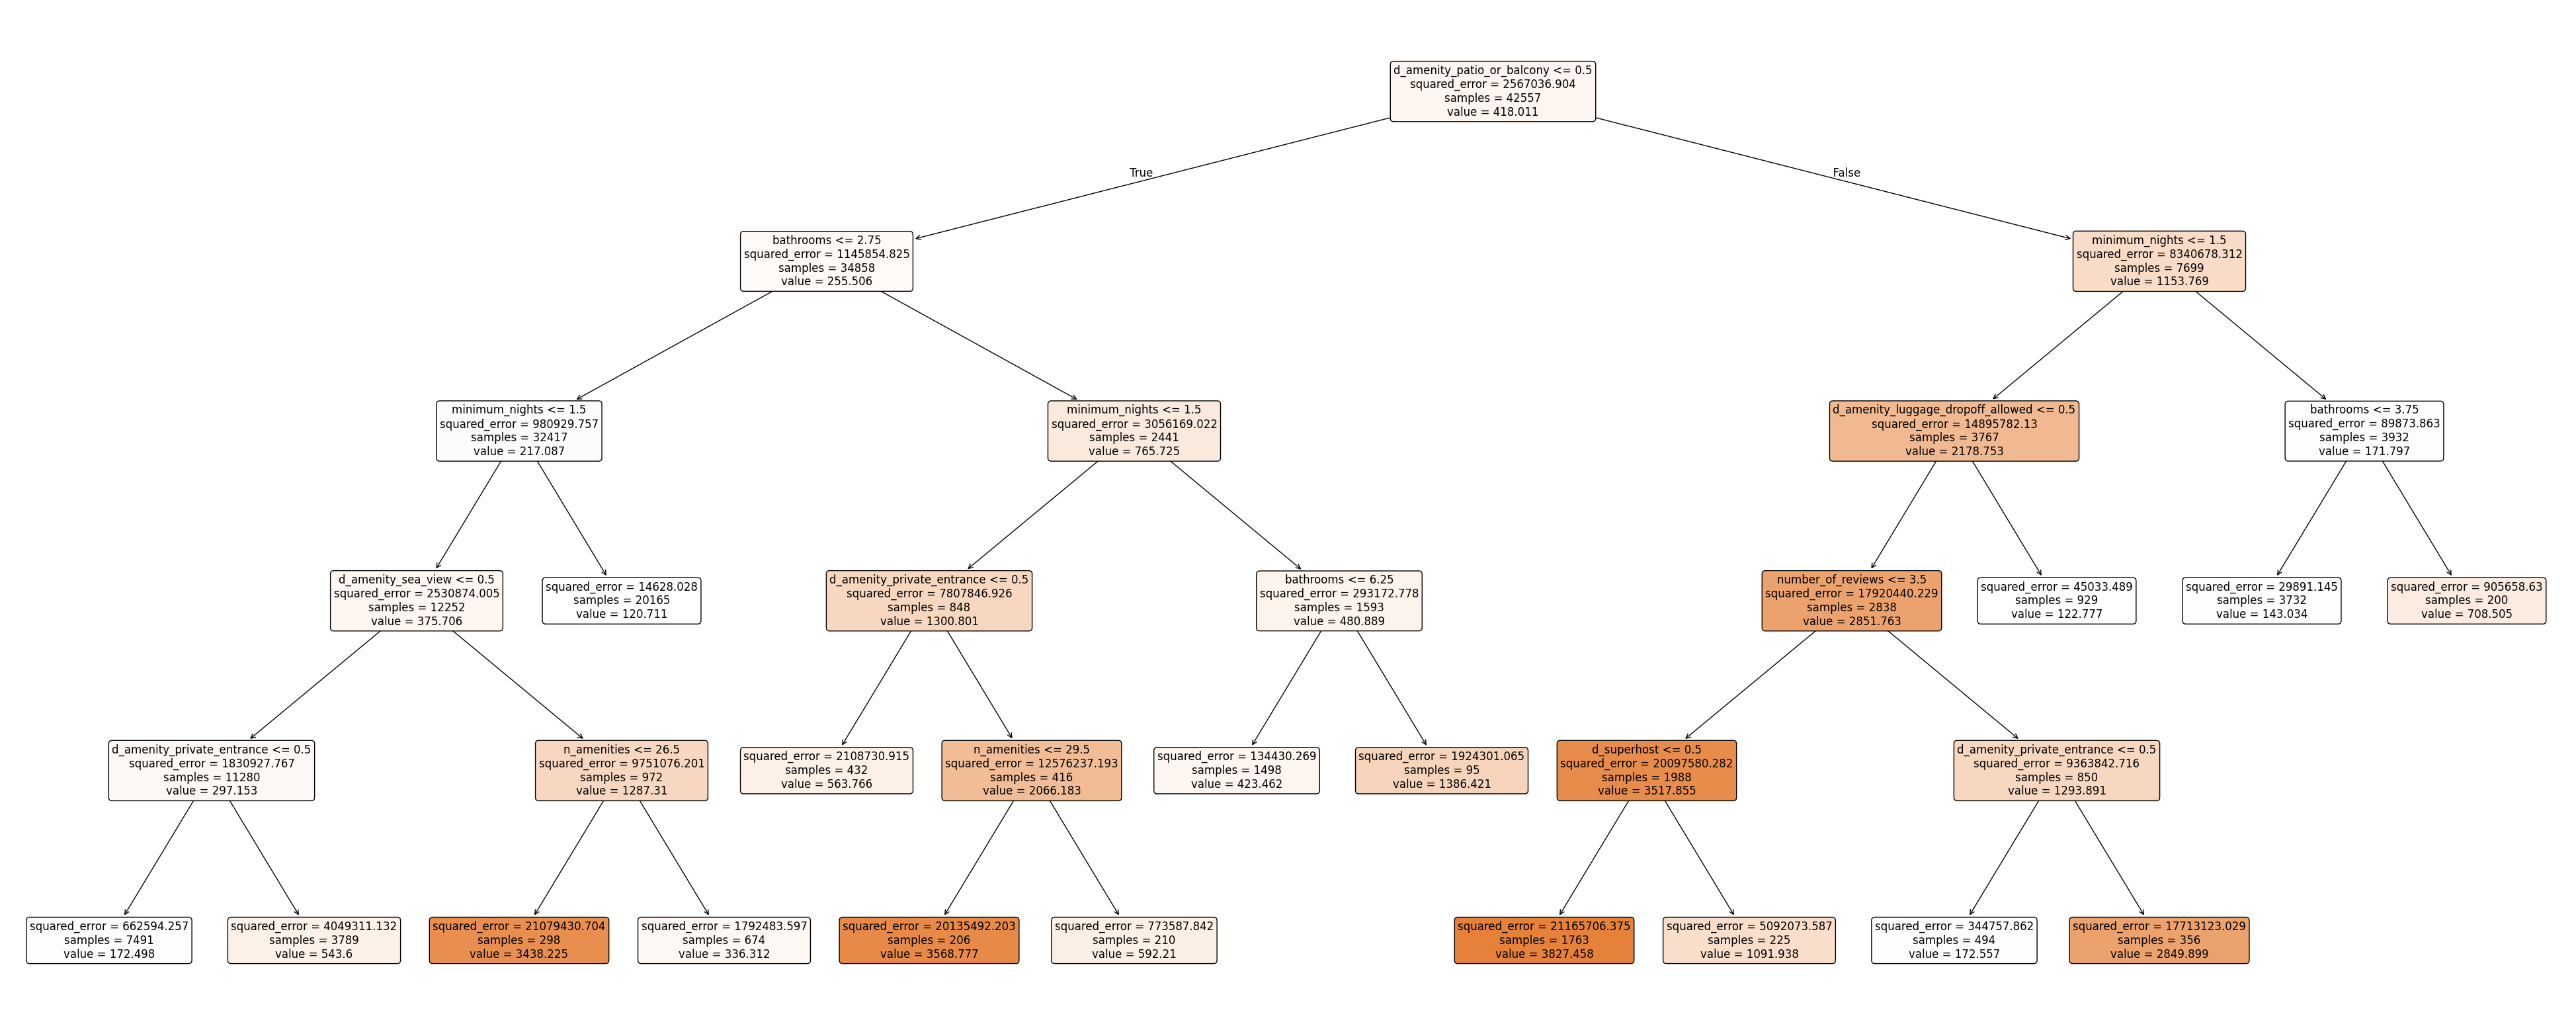

In [19]:
# Plot tree
feature_names_model_cart_model_cv = X_train.design_info.column_names

plt.figure(figsize = (50,20))
tree.plot_tree(
    cart_model_cv.best_estimator_,  
    filled=True, 
    rounded=True, 
    feature_names=feature_names_model_cart_model_cv, 
    fontsize=12
)
plt.show()

<Axes: title={'center': 'CART model highest feature importances'}, xlabel='variables', ylabel='variable'>

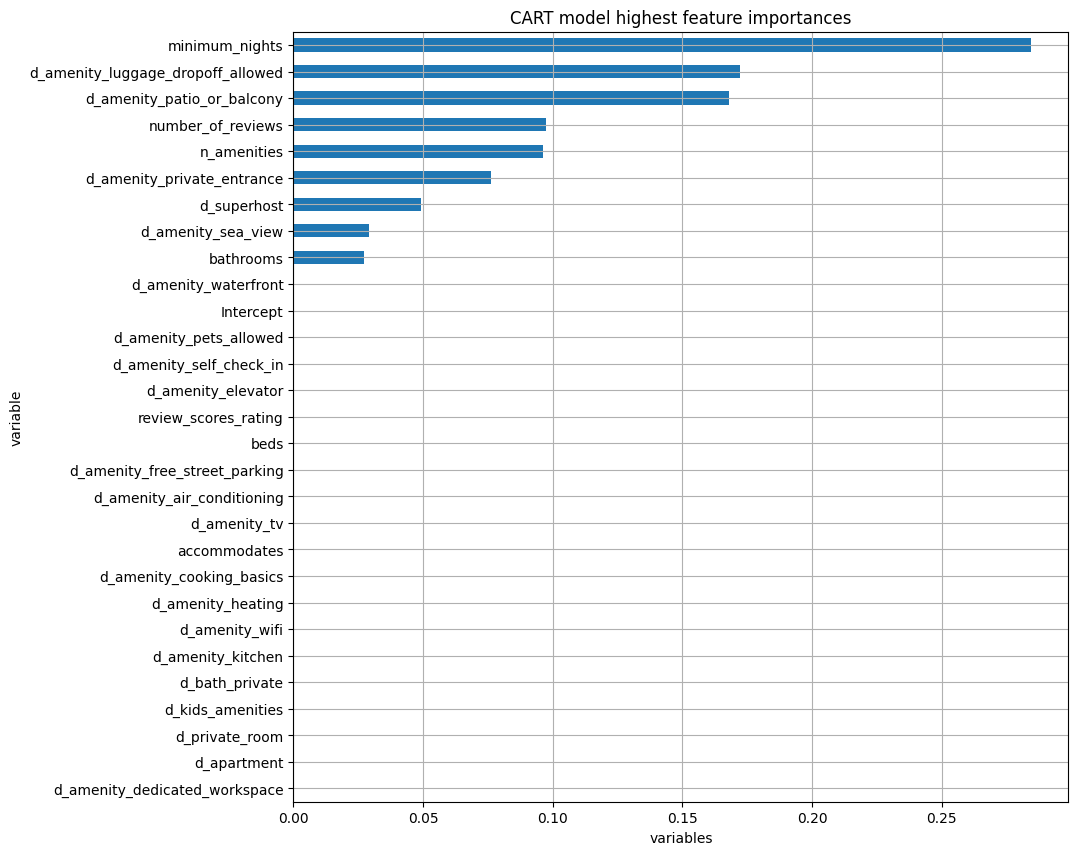

In [20]:
# Feature importance
cart_model_cv.best_estimator_.feature_importances_
pd.DataFrame(
    cart_model_cv.best_estimator_.feature_importances_, 
    X_train.design_info.column_names)
df_var_imp = pd.DataFrame(
    cart_model_cv.best_estimator_.feature_importances_, 
    X_train.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'CART model highest feature importances', 
          xlabel = 'variables', legend = False
         )

In [21]:
# Add CART results to model performance summary table
new_row = pd.DataFrame({
    'Model': ['CART with pruning'],
    'Number of features': [n_used_features], 
    'RMSE Train': [cart_rmse_train],
    'RMSE CV Train': [cart_cv_rmse_train],
    'RMSE Holdout City': [cart_rmse_holdout_city],
    'RMSE Holdout Time': [cart_rmse_holdout_time]
})

# Concatenate with the existing summary table
df_results = pd.concat([df_results, new_row], ignore_index=True)
df_results

,Model,Number of features,RMSE Train,RMSE CV Train,RMSE Holdout City,RMSE Holdout Time
0,OLS Model 1,6,1565.832576,NA,1531.476722,1498.686062
1,OLS Model 2,9,1551.918126,NA,1522.626715,1485.525749
2,OLS Model 3,25,1477.991406,NA,1475.320388,1426.916668
3,OLS Model 4,26,1475.062488,NA,1475.829775,1423.909328
4,OLS Model 5,28,1473.227814,NA,1475.378903,1423.235854
5,LASSO,27,1473.230799,1439.889464,1475.197130,1423.198736
6,CART with pruning,9,1362.199138,1335.857234,1413.482678,1325.306532


### 3.4 Random Forest

I saw that the decision tree didn't include other, seemingly important features so I tried the Random Forest algorithm. I did the grid tuning with 5, 10, 15, 20 and 25 maximum features and minimum sample sizes in the leaf nodes of 500, 1000 and 1500. Again, I used the cross-validated RMSE for model selection. Overall, the model used 25 different features. The most important features in this model correspond to the features in the decision tree model. The RMSE is significantly lower in the different city holdout set than the previous models, however, almost 3 times as many features were used in this model.

In [22]:
seed = 20260202
y_train, X_train = dmatrices(ols_model_5, df_train_clean)
y_holdout_city, X_holdout_city = dmatrices(ols_model_5, df_holdout_city_clean)
y_holdout_time, X_holdout_time = dmatrices(ols_model_5, df_holdout_time_clean)

# Fit RF model on training data
rfr = RandomForestRegressor(random_state = seed)
tune_grid = {"max_features": [5, 10, 15, 20, 25], "min_samples_leaf": [500, 1000, 1500]}
rf_model_cv= GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)
rf_model = rf_model_cv.fit(X_train, y_train.ravel())
rf_cv_rmse_train = -1 * rf_model.best_score_

# Get the number of used fetures
importances_rf = rf_model.best_estimator_.feature_importances_
n_features_rf = np.sum(importances_rf > 0)

# Make predictions
pred_rf_train = rf_model_cv.predict(X_train)
pred_rf_holdout_city = rf_model_cv.predict(X_holdout_city)
pred_rf_holdout_time = rf_model_cv.predict(X_holdout_time)

# Calculate RMSE
rf_rmse_train = mean_squared_error(y_train, pred_rf_train, squared=False)
rf_rmse_holdout_city = mean_squared_error(y_holdout_city, pred_rf_holdout_city, squared=False)
rf_rmse_holdout_time = mean_squared_error(y_holdout_time, pred_rf_holdout_time, squared=False)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END max_features=5, min_samples_leaf=500;, score=-583.215 total time=   1.4s
[CV 2/5] END max_features=5, min_samples_leaf=500;, score=-783.018 total time=   1.6s
[CV 3/5] END max_features=5, min_samples_leaf=500;, score=-1425.714 total time=   1.9s
[CV 4/5] END max_features=5, min_samples_leaf=500;, score=-1635.335 total time=   1.8s
[CV 5/5] END max_features=5, min_samples_leaf=500;, score=-2265.370 total time=   2.0s
[CV 1/5] END max_features=5, min_samples_leaf=1000;, score=-602.223 total time=   1.5s
[CV 2/5] END max_features=5, min_samples_leaf=1000;, score=-798.122 total time=   1.3s
[CV 3/5] END max_features=5, min_samples_leaf=1000;, score=-1456.317 total time=   1.4s
[CV 4/5] END max_features=5, min_samples_leaf=1000;, score=-1674.484 total time=   1.4s
[CV 5/5] END max_features=5, min_samples_leaf=1000;, score=-2330.853 total time=   1.4s
[CV 1/5] END max_features=5, min_samples_leaf=1500;, score=-601.706 

<Axes: title={'center': 'Random forest model highest feature importances'}, xlabel='variables', ylabel='variable'>

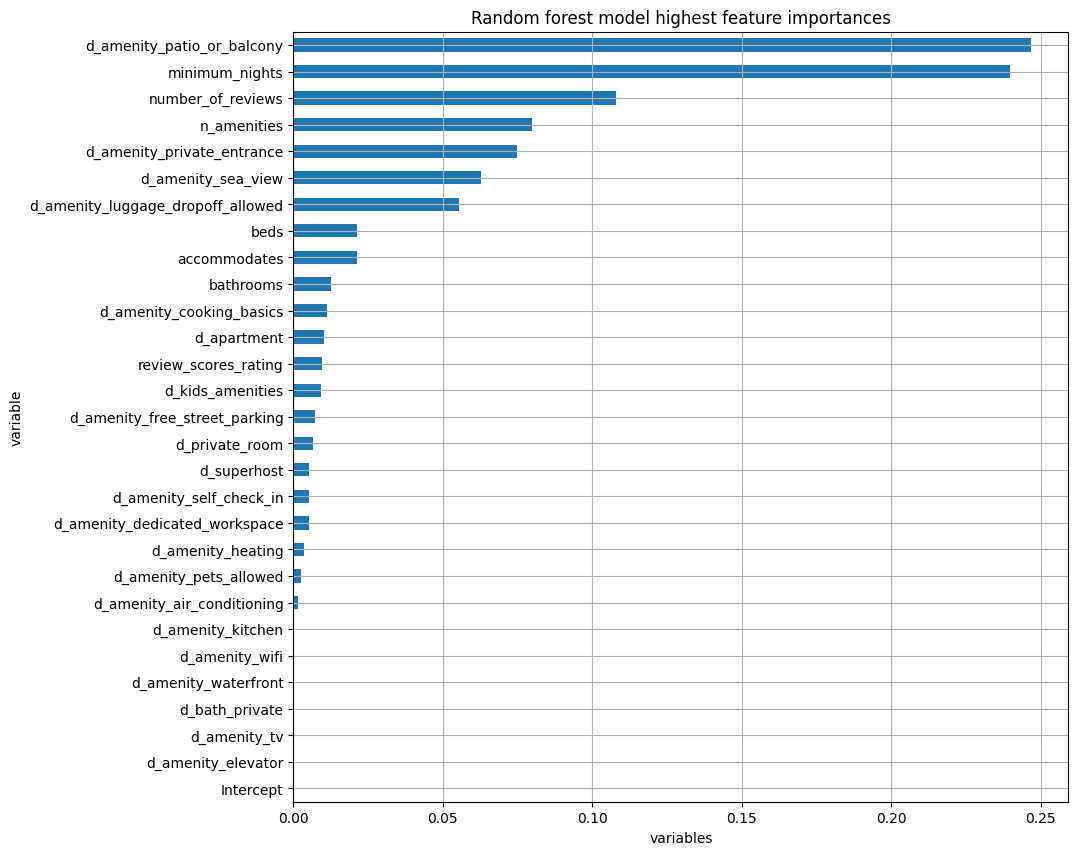

In [23]:
# Feature importance
rf_model.best_estimator_.feature_importances_
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X_train.design_info.column_names)
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X_train.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         )


In [24]:
# Add Random Forest results to model performance summary table
new_row = pd.DataFrame({
    'Model': ['Random Forest'],
    'Number of features': [n_features_rf], 
    'RMSE Train': [rf_rmse_train],
    'RMSE CV Train': [rf_cv_rmse_train],
    'RMSE Holdout City': [rf_rmse_holdout_city],
    'RMSE Holdout Time': [rf_rmse_holdout_time]
})

# Concatenate with the existing summary table
df_results = pd.concat([df_results, new_row], ignore_index=True)
df_results

,Model,Number of features,RMSE Train,RMSE CV Train,RMSE Holdout City,RMSE Holdout Time
0,OLS Model 1,6,1565.832576,NA,1531.476722,1498.686062
1,OLS Model 2,9,1551.918126,NA,1522.626715,1485.525749
2,OLS Model 3,25,1477.991406,NA,1475.320388,1426.916668
3,OLS Model 4,26,1475.062488,NA,1475.829775,1423.909328
4,OLS Model 5,28,1473.227814,NA,1475.378903,1423.235854
5,LASSO,27,1473.230799,1439.889464,1475.197130,1423.198736
6,CART with pruning,9,1362.199138,1335.857234,1413.482678,1325.306532
7,Random Forest,25,1376.463562,1329.131177,1380.771679,1335.638937


### 3.5 GBM

Finally I used the GBM boosting model. Did the grid tuning with 20 and 30 estimators with the maximum depth of 5 and 10. The train RMSE dropped but the test RMSE is only slightly lower compared to the Random Forest (unfortunately I had to run the model twice because first time I messed up, that's why it is appended twice to the model comparison table).

In [28]:
numerical_columns = ols_model_5.split('~')[1].split('+')

y_train = df_train_clean['price']
X_train = df_train_clean[numerical_columns]
y_holdout_city = df_holdout_city_clean['price']
X_holdout_city = df_holdout_city_clean[numerical_columns]
y_holdout_time = df_holdout_time_clean['price']
X_holdout_time = df_holdout_time_clean[numerical_columns]

# Define GBM model with hyperparameter tuning
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )
tune_grid = {"n_estimators": [20, 30], "max_depth": [5, 10]}
gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

# Define pipeline
preprocessing = ColumnTransformer(
    [
        ("num", "passthrough", numerical_columns),
    ]
)
gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

# Fit GBM model
gbm_pipe.fit(X_train,y_train)
gbm_model_cv.best_estimator_
gbm_cv_rmse = gbm_model_cv.best_score_*-1

# Make predictions
pred_gbm_train = gbm_model_cv.predict(X_train)
pred_gbm_holdout_city = gbm_model_cv.predict(X_holdout_city)
pred_gbm_holdout_time = gbm_model_cv.predict(X_holdout_time)

# Calculate RMSE
gbm_rmse_train = mean_squared_error(y_train, pred_gbm_train, squared=False)
gbm_rmse_holdout_city = mean_squared_error(y_holdout_city, pred_gbm_holdout_city, squared=False)
gbm_rmse_holdout_time = mean_squared_error(y_holdout_time, pred_gbm_holdout_time, squared=False)


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  10.1s


In [29]:
# Add GBM results to model performance summary table
new_row = pd.DataFrame({
    'Model': ['GBM'],
    'Number of features': ['NA'], 
    'RMSE Train': [gbm_rmse_train],
    'RMSE CV Train': [gbm_cv_rmse],
    'RMSE Holdout City': [gbm_rmse_holdout_city],
    'RMSE Holdout Time': [gbm_rmse_holdout_time]
})

# Concatenate with the existing summary table
df_results = pd.concat([df_results, new_row], ignore_index=True)
df_results

,Model,Number of features,RMSE Train,RMSE CV Train,RMSE Holdout City,RMSE Holdout Time
0,OLS Model 1,6,1565.832576,NA,1531.476722,1498.686062
1,OLS Model 2,9,1551.918126,NA,1522.626715,1485.525749
2,OLS Model 3,25,1477.991406,NA,1475.320388,1426.916668
3,OLS Model 4,26,1475.062488,NA,1475.829775,1423.909328
4,OLS Model 5,28,1473.227814,NA,1475.378903,1423.235854
5,LASSO,27,1473.230799,1439.889464,1475.197130,1423.198736
6,CART with pruning,9,1362.199138,1335.857234,1413.482678,1325.306532
7,Random Forest,25,1376.463562,1329.131177,1380.771679,1335.638937
8,GBM,NA,614.740106,1147.507808,1386.243620,1109.232134
9,GBM,NA,934.419139,1105.705428,1340.505920,1122.376528


## 4. Summary

While simpler OLS and LASSO models provided a solid baseline with intuitive coefficients, the more complex tree-based methods (Random Forest and GBM) produced better predictive performance. Specifically, the Random Forest model achieved a significantly lower RMSE on the city holdout set, suggesting it generalized better to new locations than the single Decision Tree. Although the GBM model offered the lowest training error, compared to the Random Forest the improvement was marginal for the cost of increased complexity. The simplest algorithm-based model was the CART with 9 features.